# Lab 8 - Graph Data Analytics

Complete the code with TODO tag.

If you haven't installed networkx package, you can run the following command (note the exclamation mark)

```bash
!conda install networkx --yes
```

## 1. Centrality Analysis
In this exercise, you will implement the pagerank centrality.

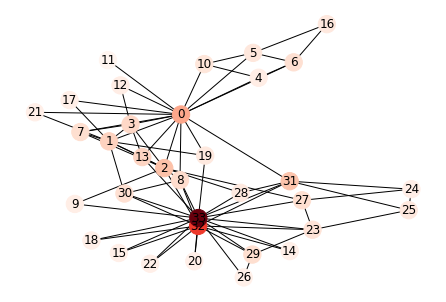

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def pagerank_centrality(G, iter=100):
    p = np.array([1 for i in G.nodes()])
    A = nx.adjacency_matrix(G)

    for k in range(iter):
        for i in G.nodes():
            for j in G.nodes():
                
                # Don't calculate if not connected
                if A[i,j] == 0:
                    continue
                
                numer = p[j]
                denom = G.degree(j)
                
                # Edge weight times (pagerank centrality of j / degree of j)
                p[i] += A[i,j] * (numer/denom)
                
        
        norm = 5
        p = p / norm
    return p


G = nx.karate_club_graph()
values = pagerank_centrality(G)
nx.draw(G, cmap=plt.get_cmap('Reds'), node_color = values, with_labels=True)

## 2. Community Analysis

### 2.1. Clique Percolation Method

One well-known algorithm for detecting overlapping communities is called the Clique Percolation Method (CPM).

In [18]:
from itertools import combinations

testme = None

def get_percolated_cliques(G, k):
    perc_graph = nx.Graph()
    
    cliques = [frozenset(clique) for clique in nx.find_cliques(G) if len(clique) == k]
    
    # For each pair of cliques...
    for c1, c2 in combinations(cliques, 2):
        
        # If they share k-1 nodes, add an edge between them on the perc graph
        intersect = frozenset.intersection(c1, c2)
        if len(intersect) == k-1:
            perc_graph.add_edge(c1,c2)

    #  Yield the union of all connected cliques within each group
    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))

Test with a small dataset

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882
---0.0006248950958251953 seconds---


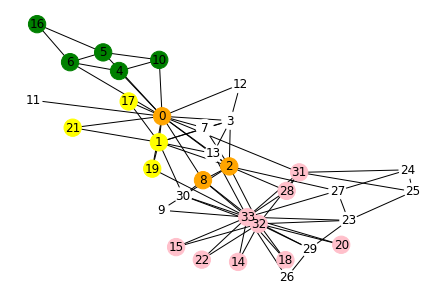

In [45]:
def partition(communities):
#     node2communities = dict()
    colors = [0] * len(G)
    for hood in range(len(communities)):
        for node in communities[hood]:
            colors[node] = hood+1

    return colors

G = nx.karate_club_graph()
print(nx.info(G))

import time
start_time = time.time()
communities = list(get_percolated_cliques(G,3))
print("---{0} seconds---".format(time.time() - start_time))

colors = partition(communities)

color_choices = ['white', 'yellow', 'green', 'orange', 'pink', 'blue']

cols = [color_choices[c] for c in colors]
nx.draw(G, node_color = cols, with_labels=True)

### 2.2. Efficient Implementation
That implementation is correct but expensive---it requires O(N^2) clique comparisons, where N is the number of cliques (which is often much larger than the number of nodes!).  If we use a python dictionary to index which nodes belong to which cliques, then we can easily compare only those cliques that share at least one node in common.  This implementation is a bit longer but should be more efficient:

---0.0009300708770751953 seconds---


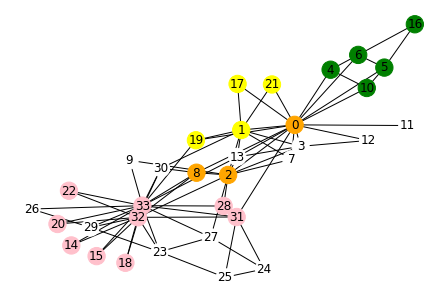

In [61]:
def get_percolated_cliques2(G, k):
    perc_graph = nx.Graph()
    
    cliques = [frozenset(clique) for clique in nx.find_cliques(G) if len(clique) == k]
    
    membership_dict = defaultdict(list)
    
    for clique in cliques:
        for node in clique:
            membership_dict[node].append(clique)
    
    for clique in cliques:
        for adj_clique in get_adjacent_cliques(clique, membership_dict):
            # If they share k-1 nodes, add an edge between them on the perc graph
            intersect = frozenset.intersection(clique, adj_clique)
            if len(intersect) == k-1:
                perc_graph.add_edge(clique, adj_clique)

    for component in nx.connected_components(perc_graph):
        yield(frozenset.union(*component))
        

def get_adjacent_cliques(clique, membership_dict):
    adjacent_cliques = set()
        
    for n in clique:
        for adj_clique in membership_dict[n]:
            if clique != adj_clique:
                adjacent_cliques.add(adj_clique)
    return adjacent_cliques
    
    
    print(membership_dict)

start_time = time.time()
communities = list(get_percolated_cliques2(G,3))
print("---{0} seconds---".format(time.time() - start_time))

colors = partition(communities)

color_choices = ['white', 'yellow', 'green', 'orange', 'pink', 'blue']

cols = [color_choices[c] for c in colors]
nx.draw(G, node_color = cols, with_labels=True)



### 2.3. Test with large dataset

Now we test with a real large-scale network data at https://snap.stanford.edu/data/com-Amazon.html

In [64]:
# G = nx.read_edgelist("email-Eu-core.txt")
G = nx.read_edgelist("com-amazon.ungraph.txt")
print(nx.info(G))

start_time = time.time()
communities = get_percolated_cliques(G, 3)
print("---{0} seconds---".format(time.time() - start_time))

start_time = time.time()
communities = get_percolated_cliques2(G, 3)
print("---{0} seconds---".format(time.time() - start_time))

Name: 
Type: Graph
Number of nodes: 334863
Number of edges: 925872
Average degree:   5.5299
---0.33260083198547363 seconds---
---8.511543273925781e-05 seconds---
